## Setting Thresholds For Anomaly Detection in Download Speed

### Background
Worker Agent uses Job Attachment module to download input files from an S3 bucket. During the download process, Job Attachment provides progress reports periodically using callback, which include information about the current (or average) transfer rate (in bytes/s). We are looking to implement a feature where, If the transfer rate falls below a certain **speed threshold** for a duration bigger than a specific **time threshold**, the download process is halted. This is to identify transfer speeds slow enough to reasonably imply system or network issues.

### Objective
The key question is how to determine the hard-coded threshold values for transfer rate and time duration. These values should keep a balance between not prematurely terminating downloads and not allowing them to continue for too long with very low transfer speeds.

### Simulation Approach
Since we don't have real-world data about the transfer rate yet, we decided to simulate the download process based on the following assumptions:

1. Transfer speed
We assume the transfer speed at any given time (unless it is within the slowdown duration) follows a normal distribution. The mean for this distribution is derived from average internet speeds of North America, which is 12.5 MB/s. The standard deviation is set as 2.5 (without any specific underlying rationale.)

2. Slowdown occurrence
For each download session in our simulation, we assume that a single time of significant slowdown will occur. The start time, duration, and rate of this slowdown are randomly determined as below, where `expected end time` is (Transfer size) / (Mean speed). 
    - start time: a random value from [0, `expected end time`]
    - end time: a random value from [1, 2 * `expected end time` - start time + 1]
      - We assume that problematic slowdowns could last long enough to raise concerns about time and monetary costs, so we consider durations up to twice the expected total time.
    - slowdown rate: a random value from [99.9%, 99.99%]
      - We assume the speed should drop huge enough to feel almost stopped.

For each simulated download session, we test various combinations of speed and time thresholds.


### Parameters and Assumptions

In [14]:
MEAN_SPEED = 12.5 * 10**6  # 100 Mbps in B/s
STD_DEV_FOR_SPEED = 2.5 * 10**6  # MEAN_SPEED / 5
SLOWDOWN_RATE_RANGE = (0.999, 0.9999)  # 99.9% to 99.99% slowdown (e.g., 100 Mbps --> 0.1 Mbps)
TRANSFER_SIZES = [10 * 10**9]  # bytes
SPEED_THRESHOLDS = [
    1 * 10**3,
    2 * 10**3,
    5 * 10**3,
    10 * 10**3,
    50 * 10**3,
    100 * 10**3,
    200 * 10**3,
    500 * 10**3,
    1 * 10**6,
    2 * 10**6,
    5 * 10**6,
    10 * 10**6,
]  # B/s,
TIME_THRESHOLDS = [1, 2, 3, 4, 5, 10, 15, 20]  # minutes
MEASURE_INTERVAL = 1 * 60  # seconds

### Classes / methods for Running Simulation 


In [15]:
from dataclasses import dataclass
from typing import List
import numpy as np
import random


@dataclass
class SimulationEnv:
    """
    Transfer speed profile, start time and duration of delay occurrence
    """

    transfer_size: int
    speed_profile: list[tuple[float, int]]
    slowdown_speed_mean: float
    slowdown_start: int
    slowdown_end: int
    slowdown_duration: int


@dataclass
class SimulationResult:
    """
    A combination of speed threshold and time threshold... and a simulation result.
    """

    speed_threshold: float
    time_threshold: int
    false_positive: bool
    completed_but_cancelled: bool = False
    worker_time: float = 0  # Time taken to complete the download / max possible time

    # Make the class iterable
    def __iter__(self):
        yield self

    @classmethod
    def get_average_time(cls, results: List["SimulationResult"]) -> float:
        if not results:
            return 0.0

        total = sum(result.worker_time for result in results)
        return total / len(results)


def create_simulation_env(
    transfer_size: int,
) -> SimulationEnv:
    """
    Create a simulation environment with a randomized speed profile and
    a single occurance of randomized slowdown.
    """
    slowdown_start = random.randint(0, transfer_size / MEAN_SPEED)  # seconds
    slowdown_duration = random.randint(
        1, transfer_size * 2 / MEAN_SPEED - slowdown_start + 1
    )  # seconds
    slowdown_end = slowdown_start + slowdown_duration
    slowdown_rate = random.uniform(SLOWDOWN_RATE_RANGE[0], SLOWDOWN_RATE_RANGE[1])
    slowdown_speed_mean = (1 - slowdown_rate) * MEAN_SPEED  # in B/s
    slowdown_speed_std_dev = (1 - slowdown_rate) * 0.1

    time = 0
    downloaded_so_far = 0  # bytes
    speed_profile: list[tuple[float, int]] = []

    while downloaded_so_far < transfer_size:
        if time >= slowdown_start and time < slowdown_end:
            speed = np.random.normal(slowdown_speed_mean, slowdown_speed_std_dev)
        else:
            speed = np.random.normal(MEAN_SPEED, STD_DEV_FOR_SPEED)
        current_speed = speed
        # calculate how much data is downloaded (cumulative)
        downloaded_so_far += current_speed * 1
        time += 1
        speed_profile.append((speed, transfer_size - downloaded_so_far))

    return SimulationEnv(
        transfer_size=transfer_size,
        speed_profile=speed_profile,
        slowdown_speed_mean=slowdown_speed_mean,
        slowdown_start=slowdown_start,
        slowdown_end=slowdown_end,
        slowdown_duration=slowdown_duration,
    )


# Run a simulation with thresholds combination
def run_simulation(
    simulation_env: SimulationEnv,
    measure_interval: int,
    speed_threshold: float,
    time_threshold: int,
) -> SimulationResult:
    speeds_to_avg = []  # in B/s
    time_in_interval = 0  # in seconds
    worker_time = 0  # seconds
    consecutive_slow_speed_count = 0  # count
    false_positive = None
    total_time_expectation = simulation_env.transfer_size / MEAN_SPEED  # seconds
    # Total time taken until the download completes without slowdown detection or cancelling
    max_time = len(simulation_env.speed_profile)  # seconds

    for i, (speed, _) in enumerate(simulation_env.speed_profile):
        speeds_to_avg.append(speed)
        time_in_interval += 1
        worker_time += 1

        if time_in_interval >= measure_interval:
            # calculate avg speed over measure_interval
            assert len(speeds_to_avg) > 0
            avg_speed = sum(speeds_to_avg) / len(speeds_to_avg)  # bytes/s
            speeds_to_avg = []

            # check the measured speed against the threshold
            if avg_speed < speed_threshold:
                consecutive_slow_speed_count += 1
                if consecutive_slow_speed_count >= time_threshold:
                    false_positive = (
                        i < simulation_env.slowdown_start or i >= simulation_env.slowdown_end
                    )
                    # After detecting the slowdown and canceling the download, we assume that the user retries
                    # from the beginning when the network and speed are back to normal.
                    worker_time += total_time_expectation
                    return SimulationResult(
                        speed_threshold=speed_threshold,
                        time_threshold=time_threshold,
                        false_positive=false_positive,
                        completed_but_cancelled=True,
                        worker_time=worker_time / max_time,
                    )
            else:
                consecutive_slow_speed_count = 0
            time_in_interval = 0

    return SimulationResult(
        speed_threshold=speed_threshold,
        time_threshold=time_threshold,
        false_positive=False,
        completed_but_cancelled=False,
        worker_time=worker_time / max_time,
    )

### Run Simulation and Visulize Results by Heatmap

In [ ]:
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

num_simulations = 1000
results = defaultdict(list)
for transfer_size in TRANSFER_SIZES:
    for _ in range(num_simulations):
        sim_env = create_simulation_env(transfer_size)
        for speed_threshold in SPEED_THRESHOLDS:
            for time_threshold in TIME_THRESHOLDS:
                key = (speed_threshold, time_threshold)
                # Run a simulation and append the result to dictionary
                results[key].append(
                    run_simulation(sim_env, MEASURE_INTERVAL, speed_threshold, time_threshold)
                )

    # the list of all speed thresholds used in simulations
    speed_thresholds = [key[0] / 10**3 for key in results.keys()]  # KB/s
    # the list of all time thresholds used in simulations
    time_thresholds = [key[1] for key in results.keys()]
    # the list of average times for each combination of speed and time thresholds
    avg_time_list = [
        SimulationResult.get_average_time(results_list) for results_list in list(results.values())
    ]

    df = pd.DataFrame(
        {"Speed thres": speed_thresholds, "Time thres": time_thresholds, "Avg time": avg_time_list}
    )

    pivot_table = df.pivot_table(values="Avg time", index="Time thres", columns="Speed thres")

    # Draw a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.xlabel("Speed Threshold (KB/s)")
    plt.ylabel("Time Threshold (Minutes)")
    plt.title("Heatmap of Worker Runtime")
    plt.show()

### Sample Results and Analysis

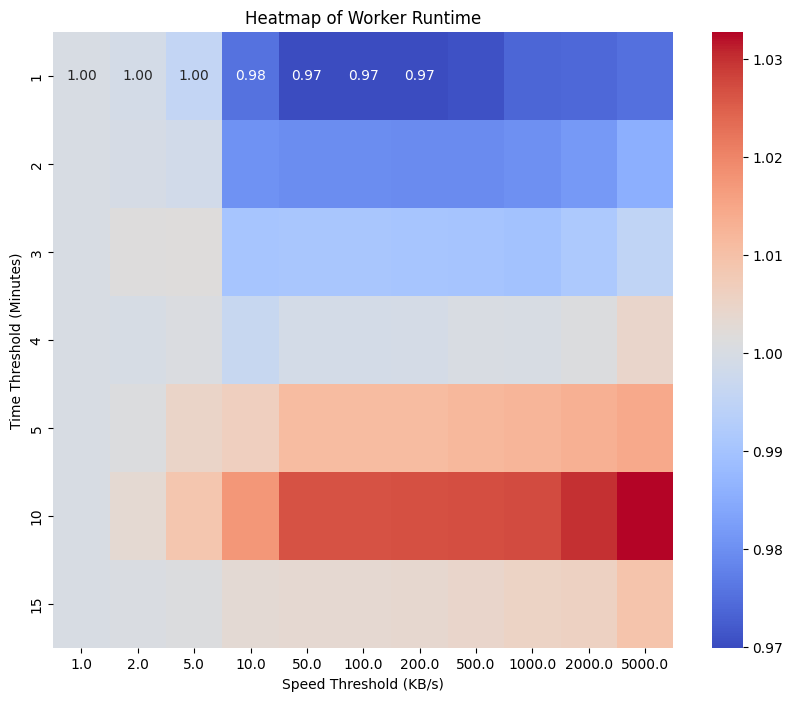

This simulation is based on a lot of assumptions, making it difficult to be a good reflection of real-world situation, and there may be many disagreement in interpreting the results. Nevertheless, some key points that can be derived from these heatmap results are as follows:

- When the speed threshold is set too low (less than 10 KB/s), even if a significant speed degradation occurs from the original speed (99.99% or more), this slowdown itself may not be detected.

- When the time threshold exceeds a certain level (more than 4-5 minutes), it does not seem to have a significant impact on time or cost savings in the context of threshold-based cancellation. (However, as mentioned earlier, caution is required in interpreting these results: we do not assume extremely long durations of slowdown - in this simulation, we limit it to twice the expected download time. Furthermore, we assume that after halting the download, a new session starts to download files from the beginning. Therefore, in some cases, it may appear that it is better to continue downloading until it fully recovers the normal speed, rather than stopping it in the middle.)

- Based on this heatmap, the most suitable range for threshold values appears to be as follows:
  - Speed threshold: 50 - 200 KB/s
  - Time threshold: 1 - 3 minutes
